# 02 - Análise de Dados

Este notebook busca consumir os dados gerados das notas obtidas nas graduações e na pós-graduação para gerar os gráficos disponibilizados na página.

## Importações

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots

## Constantes e sets

In [2]:
GRADES_COLOR_MAP = {
    'A': '#60D394',
    'B': '#AAF683',
    'C': '#FFD97D',
    'D': '#FF9B85',
    'F': '#EE6055' 
}

# HEATMAP_PALETTE = 'RdYlGn'
# HEATMAP_PALETTE = 'RdBu'
# HEATMAP_PALETTE = 'Reds'
# HEATMAP_PALETTE = 'Blues'
HEATMAP_PALETTE = 'Teal'
# HEATMAP_PALETTE = 'Magma_r'
# HEATMAP_PALETTE = 'OrRd'

BLUE =  '#73A1B2'
GREEN = '#6E8658'
BROWN = '#57473A'

SUBPLOT_TITLES = ['Meus conceitos<br>&nbsp;', 'Projeção estimada<br>pela média', 'Projeção estimada<br>pela moda']

# RENDERER = None  # Interativo
RENDERER = 'png'  # Para ter preview no GitHub/Nbviewer

# template = 'plotly'  # Padrão
template = 'plotly_white'  # Fundo branco. Melhor para embarcar no html?

pio.templates.default = template 
pio.templates[template].layout.font.family = 'Helvetica, sans-serif'  # Para usar a mesma fonte da página html
pio.templates[template].layout.font.color = 'rgb(99, 99, 99)'  # Mesma cor do HTML

# pd.options.mode.chained_assignment = 'warn'
pd.options.mode.chained_assignment = None  # Para remover warnings desnecessários

## Scripts

### Análise dos dados da UFABC

#### Leitura dos dados

Como primeiro passo, vamos fazer a leitura da base de dados das minhas notas (obtidas pela consulta ao Sigaa) e depois para as notas médias dos alunos que seguiram a mesma trajetória.

In [3]:
df_ufabc = pd.read_csv('./data/notas-ufabc.csv', dtype={'Ano': str}, sep=';')
df_ufabc

Ano      Código                                         Disciplina  \
0   2017.2  BIL0304-15         EVOLUÇÃO E DIVERSIFICAÇÃO DA VIDA NA TERRA   
1   2017.2  BCS0001-15            BASE EXPERIMENTAL DAS CIÊNCIAS NATURAIS   
2   2017.2  BIS0005-15                    BASES COMPUTACIONAIS DA CIÊNCIA   
3   2017.2  BIK0102-15                               ESTRUTURA DA MATÉRIA   
4   2017.2  BIS0003-15                                  BASES MATEMÁTICAS   
..     ...         ...                                                ...   
73  2023.2  ESTA017-17                  LABORATÓRIO DE MÁQUINAS ELÉTRICAS   
74  2023.2  ESTA011-17                  AUTOMAÇÃO DE SISTEMAS INDUSTRIAIS   
75  2023.3  ESTA904-17  TRABALHO DE GRADUAÇÃO III EM ENGENHARIA DE INS...   
76  2023.3  ESTA022-17                   TEORIA DE ACIONAMENTOS ELÉTRICOS   
77  2023.3  ESTA008-17                            SISTEMAS DE CONTROLE II   

   Resultado  Situação  
0          C  APROVADO  
1          A  APROVADO  
2          A  APROVADO  
3          A  APROVADO  
4          C  APROVADO  
..       ...       ...  
73         A  APROVADO  
74         A  APROVADO  
75         A  APROVADO  
76         A  APROVADO  
77         A  APROVADO  

[78 rows x 5 columns]

Para enriquecermos nossa base de dados e podermos fazer análises referentes ao CR, precisamosadicionar informações como o número de créditos. Como esta informação não está disponível no Sigaa, vamos consultar uma base externa do [Catálogo de Disciplinas da UFABC](https://prograd.ufabc.edu.br/catalogos-de-disciplinas) (em específico a [edição de 2017](https://prograd.ufabc.edu.br/pdf/catalogo_disciplinas_graduacao_2017_2018_v2.xlsx)). Assim, vamos realizar a leitura dos dados.

In [4]:
df_ufabc_creds = pd.read_excel('./data/catalogo_disciplinas_graduacao_2017_2018_v2.xlsx')
df_ufabc_creds

SIGLA                                         DISCIPLINA    TPI  \
0     ESHR022-14  Abordagens Tradicionais das Relações Internaci...  4-0-4   
1     ESZM035-17                            Aditivação de Polímeros  4-0-4   
2     ESZP041-14  Administração Pública e Reforma do Estado em P...  4-0-4   
3     ESTS016-17                                     Aerodinâmica I  4-0-5   
4     ESZS019-17                                    Aerodinâmica II  4-0-5   
...          ...                                                ...    ...   
1183  ESZA019-17                                Visão Computacional  3-1-4   
1184  MCZA031-13                                      Web Semântica  4-0-4   
1185  NHT1063-15                        Zoologia de Invertebrados I  2-4-3   
1186  NHT1064-15                       Zoologia de Invertebrados II  2-4-3   
1187  NHT1065-15                            Zoologia de Vertebrados  4-2-3   

                                           RECOMENDAÇÃO  \
0                                                Não há   
1           Síntese de Polímeros; Materiais Poliméricos   
2                                                Não há   
3                                     Dinâmica de Gases   
4                                        Aerodinâmica I   
...                                                 ...   
1183                            Fundamentos de Robótica   
1184                            Inteligência Artificial   
1185                         Sistemática e Biogeografia   
1186  Sistemática e Biogeografia; Zoologia de Invert...   
1187  Sistemática e Biogeografia; Zoologia de Invert...   

                                              OBJETIVOS  \
0                                                   NaN   
1     Adquirir habilidades sobre o entendimento dos ...   
2     A disciplina visa apresentar aos alunos a vari...   
3     Familiarizar o aluno com a física associada à ...   
4     Familiarizar o aluno com a física de escoament...   
...                                                 ...   
1183  Compreender como se realizam diversas possibil...   
1184                                                NaN   
1185                                                NaN   
1186                                                NaN   
1187                                                NaN   

                                                 EMENTA  \
0     Contextualização histórica da emergência das t...   
1     Tipos de aditivos e métodos para obtenção de f...   
2     Estado, política e administração pública; Cris...   
3     Força de Sustenção e arrasto; Teoria do perfil...   
4     Física do escoamento subsônico e hipersônico. ...   
...                                                 ...   
1183  Formação da imagem; extração de atributos; vis...   
1184  Introdução à Web Semântica (WS). Linguagens pa...   
1185  Fundamentos de sistemática; Origem de Metazoa ...   
1186  Plano-básico de Deuterostomia; Filogenia de Ec...   
1187  Filogenia de Chordata (Urochordata, Cephalocho...   

                                    BIBLIOGRAFIA BÁSICA  \
0     CARR, Edward Hallett. Vinte anos de crise 1919...   
1     BART, J.C.J. Additives in Polymer: industrial ...   
2     BRESSER-PEREIRA, L. C. (1998). Reforma do esta...   
3     ANDERSON, J. D. Fundamentals of Aerodynamics. ...   
4     ANDERSON J. D. Hypersonic and High Temperature...   
...                                                 ...   
1183  BORENSTEIN, J.; EVERETT, H. R.; FENG, Liqang; ...   
1184  HITZLER, P., KRÖTZSCH, M., RUDOLPH, S. Foundat...   
1185  BRUSCA, Richard C.; BRUSCA, Gary J. Invertebra...   
1186  BRUSCA, Richard C.; BRUSCA, Gary J. Invertebra...   
1187  BRUSCA, Richard C.; BRUSCA, Gary J. Invertebra...   

                              BIBLIOGRAFIA COMPLEMENTAR  
0     ARON, Raymond. Paz e Guerra entre as Nações. S...  
1     CANEVAROLO JR, S. V., Ciência dos Polímeros, A...  
2     ABRUCIO, Fernando Luiz; LOUREIRO, Maria Rita (...  
3     

Para a nossa análise, só será necessário ter conhecimento da sigla e do TPI, informação essa que traz o número de créditos (soma de T e P).

In [5]:
df_ufabc_creds = df_ufabc_creds[['SIGLA', 'TPI']]
df_ufabc_creds['Créditos'] = df_ufabc_creds['TPI'].apply(lambda s: int(s.split('-')[0]) + int(s.split('-')[1]))
df_ufabc_creds

SIGLA    TPI  Créditos
0     ESHR022-14  4-0-4         4
1     ESZM035-17  4-0-4         4
2     ESZP041-14  4-0-4         4
3     ESTS016-17  4-0-5         4
4     ESZS019-17  4-0-5         4
...          ...    ...       ...
1183  ESZA019-17  3-1-4         4
1184  MCZA031-13  4-0-4         4
1185  NHT1063-15  2-4-3         6
1186  NHT1064-15  2-4-3         6
1187  NHT1065-15  4-2-3         6

[1188 rows x 3 columns]

Feito isso, podemos juntar as bases e ver se há alguma matéria que não teve correspondência.

In [6]:
df_ufabc = df_ufabc.join(df_ufabc_creds.set_index('SIGLA'), on='Código', how='left')
df_ufabc

Ano      Código                                         Disciplina  \
0   2017.2  BIL0304-15         EVOLUÇÃO E DIVERSIFICAÇÃO DA VIDA NA TERRA   
1   2017.2  BCS0001-15            BASE EXPERIMENTAL DAS CIÊNCIAS NATURAIS   
2   2017.2  BIS0005-15                    BASES COMPUTACIONAIS DA CIÊNCIA   
3   2017.2  BIK0102-15                               ESTRUTURA DA MATÉRIA   
4   2017.2  BIS0003-15                                  BASES MATEMÁTICAS   
..     ...         ...                                                ...   
73  2023.2  ESTA017-17                  LABORATÓRIO DE MÁQUINAS ELÉTRICAS   
74  2023.2  ESTA011-17                  AUTOMAÇÃO DE SISTEMAS INDUSTRIAIS   
75  2023.3  ESTA904-17  TRABALHO DE GRADUAÇÃO III EM ENGENHARIA DE INS...   
76  2023.3  ESTA022-17                   TEORIA DE ACIONAMENTOS ELÉTRICOS   
77  2023.3  ESTA008-17                            SISTEMAS DE CONTROLE II   

   Resultado  Situação    TPI  Créditos  
0          C  APROVADO  3-0-4         3  
1          A  APROVADO  0-3-2         3  
2          A  APROVADO  0-2-2         2  
3          A  APROVADO  3-0-4         3  
4          C  APROVADO  4-0-5         4  
..       ...       ...    ...       ...  
73         A  APROVADO  0-2-4         2  
74         A  APROVADO  1-3-4         4  
75         A  APROVADO  0-2-4         2  
76         A  APROVADO  4-0-4         4  
77         A  APROVADO  3-2-4         5  

[78 rows x 7 columns]

In [7]:
df_ufabc[df_ufabc.isna().any(axis=1)]

Empty DataFrame
Columns: [Ano, Código, Disciplina, Resultado, Situação, TPI, Créditos]
Index: []

Feito isso, para conseguirmos comparar o desempenho com base nos valores médios dos demais alunos, vamos fazer a leitura da base de dados obtida pelo scraping do next.

In [8]:
df_next = pd.read_csv('./data/notas-next.csv', dtype={'Ano': str}, sep=';')
df_next

Disciplina     A     B     C     D  \
0          EVOLUÇÃO E DIVERSIFICAÇÃO DA VIDA NA TERRA  31.0  43.1  17.4   4.8   
1             BASE EXPERIMENTAL DAS CIÊNCIAS NATURAIS  84.6  15.4   0.0   0.0   
2                     BASES COMPUTACIONAIS DA CIÊNCIA  39.2  26.9  18.3   7.2   
3                                ESTRUTURA DA MATÉRIA  17.5  29.5  31.4  10.4   
4                                   BASES MATEMÁTICAS   8.7  15.4  25.8  15.5   
..                                                ...   ...   ...   ...   ...   
73                  AUTOMAÇÃO DE SISTEMAS INDUSTRIAIS  36.4  35.9  19.0   5.2   
74  TRABALHO DE GRADUAÇÃO III EM ENGENHARIA DE INS...  60.0  26.7   0.0   0.0   
75                   TEORIA DE ACIONAMENTOS ELÉTRICOS  26.1  30.4  22.1   9.3   
76                            SISTEMAS DE CONTROLE II   6.4  32.1  34.6  15.4   
77                 INSTRUMENTAÇÃO E METROLOGIA ÓPTICA  31.9  25.9  30.4   4.4   

       F  Nota provável Conceito provável Conceito moda  
0    3.7       2.929000                 B             B  
1    0.0       3.846000                 A             A  
2    8.4       2.813000                 B             A  
3   11.3       2.314685                 C             C  
4   34.5       1.482482                 D             F  
..   ...            ...               ...           ...  
73   3.5       2.965000                 B             A  
74  13.3       3.201000                 A             A  
75  12.0       2.493493                 B             B  
76  11.6       2.062937                 C             C  
77   7.4       1.925000                 C             A  

[78 rows x 9 columns]

Para facilitar, vamos cruzar com a base de dados do Sigaa para obter os códigos e o CR.

In [9]:
df_next = df_next.join(df_ufabc.set_index('Disciplina')[['Código', 'Créditos', 'Ano']], on='Disciplina', how='left')
df_next

Disciplina     A     B     C     D  \
0          EVOLUÇÃO E DIVERSIFICAÇÃO DA VIDA NA TERRA  31.0  43.1  17.4   4.8   
1             BASE EXPERIMENTAL DAS CIÊNCIAS NATURAIS  84.6  15.4   0.0   0.0   
2                     BASES COMPUTACIONAIS DA CIÊNCIA  39.2  26.9  18.3   7.2   
3                                ESTRUTURA DA MATÉRIA  17.5  29.5  31.4  10.4   
4                                   BASES MATEMÁTICAS   8.7  15.4  25.8  15.5   
..                                                ...   ...   ...   ...   ...   
73                  AUTOMAÇÃO DE SISTEMAS INDUSTRIAIS  36.4  35.9  19.0   5.2   
74  TRABALHO DE GRADUAÇÃO III EM ENGENHARIA DE INS...  60.0  26.7   0.0   0.0   
75                   TEORIA DE ACIONAMENTOS ELÉTRICOS  26.1  30.4  22.1   9.3   
76                            SISTEMAS DE CONTROLE II   6.4  32.1  34.6  15.4   
77                 INSTRUMENTAÇÃO E METROLOGIA ÓPTICA  31.9  25.9  30.4   4.4   

       F  Nota provável Conceito provável Conceito moda      Código  Créditos  \
0    3.7       2.929000                 B             B  BIL0304-15         3   
1    0.0       3.846000                 A             A  BCS0001-15         3   
2    8.4       2.813000                 B             A  BIS0005-15         2   
3   11.3       2.314685                 C             C  BIK0102-15         3   
4   34.5       1.482482                 D             F  BIS0003-15         4   
..   ...            ...               ...           ...         ...       ...   
73   3.5       2.965000                 B             A  ESTA011-17         4   
74  13.3       3.201000                 A             A  ESTA904-17         2   
75  12.0       2.493493                 B             B  ESTA022-17         4   
76  11.6       2.062937                 C             C  ESTA008-17         5   
77   7.4       1.925000                 C             A  ESZA013-17         4   

       Ano  
0   2017.2  
1   2017.2  
2   2017.2  
3   2017.2  
4   2017.2  
..     ...  
73  2023.2  
74  2023.3  
75  2023.3  
76  2023.3  
77  2022.3  

[78 rows x 12 columns]

In [10]:
df_next[df_next.isna().any(axis=1)]

Empty DataFrame
Columns: [Disciplina, A, B, C, D, F, Nota provável, Conceito provável, Conceito moda, Código, Créditos, Ano]
Index: []

#### Comparação da proporções dos conceitos

Como primeiro passo, vamos verificar a proporção de notas e fazer uma comparação com aquelas verificadas no next.

In [11]:
ufabc_grade_prop = df_ufabc['Resultado'].value_counts(normalize=True).reindex(['A', 'B', 'C', 'D', 'F'], fill_value=0.0)  # Para garantir que tenha todas as notas
next_prob_grade_prop = df_next['Conceito provável'].value_counts(normalize=True).reindex(['A', 'B', 'C', 'D', 'F'], fill_value=0.0)
next_mode_grade_prop = df_next['Conceito moda'].value_counts(normalize=True).reindex(['A', 'B', 'C', 'D', 'F'], fill_value=0.0)

print(ufabc_grade_prop, end='\n\n')
print(next_prob_grade_prop, end='\n\n')
print(next_mode_grade_prop)

Resultado
A    0.717949
B    0.243590
C    0.038462
D    0.000000
F    0.000000
Name: proportion, dtype: float64

Conceito provável
A    0.179487
B    0.371795
C    0.346154
D    0.102564
F    0.000000
Name: proportion, dtype: float64

Conceito moda
A    0.423077
B    0.179487
C    0.217949
D    0.012821
F    0.166667
Name: proportion, dtype: float64


Podemos fazer esta comparação tanto por meio de gráfico de barras, como por meio de gráfico de pizza:

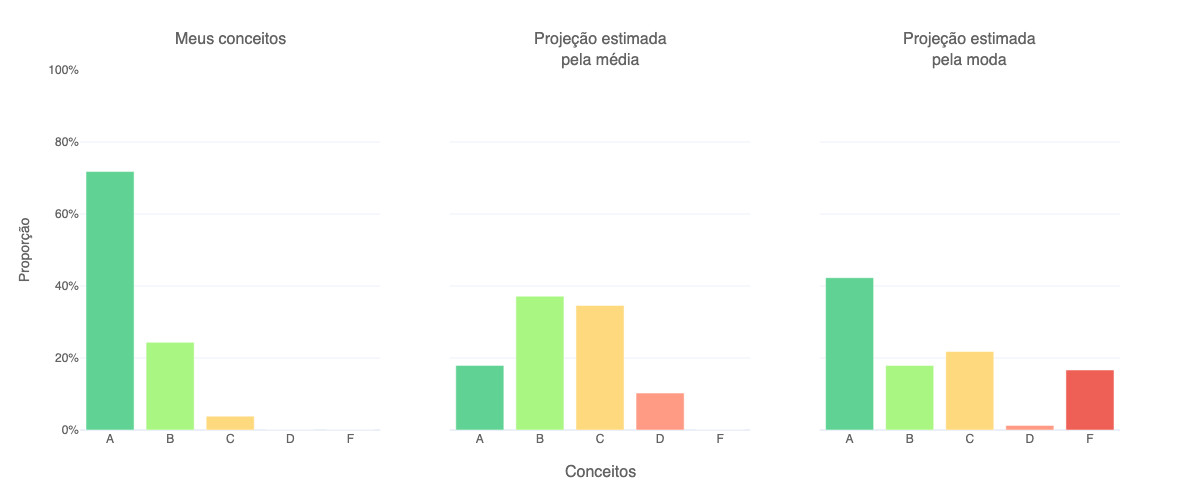

In [12]:
fig_ufabc_grades_prop_comp_bar = make_subplots(rows=1, cols=3, shared_yaxes=True, x_title='Conceitos', 
                                         subplot_titles=SUBPLOT_TITLES)

for col, (prop, name) in enumerate(zip([ufabc_grade_prop, next_prob_grade_prop, next_mode_grade_prop], SUBPLOT_TITLES)):
    x_grades_prop_bar = prop.index
    y_grades_prop_bar = prop.values
    
    grades_prop_bar_colors = [GRADES_COLOR_MAP[grade] for grade in x_grades_prop_bar]
    fig_ufabc_grades_prop_comp_bar.add_trace(go.Bar(x=x_grades_prop_bar, y=y_grades_prop_bar, showlegend=False, name=name, hovertemplate='Conceito %{x}<br>%{y:.2%}',
                                              yhoverformat='.2%', marker_color=grades_prop_bar_colors), row=1, col=col + 1)

# Tirando título para ficar mais clean no HTML. Caso seja necessário add o título de novo: 'Comparativo da proporção de notas na graduação'
fig_ufabc_grades_prop_comp_bar.update_layout({'yaxis_title': 'Proporção', 'yaxis_tickformat': '.0%', 
                                              'yaxis_range': [0, 1], 'height': 500, 'margin_t': 70, 'margin_b': 70})
fig_ufabc_grades_prop_comp_bar.write_html('../assets/graphs/ufabc_grades_prop_comp_bar.html')
fig_ufabc_grades_prop_comp_bar.update_layout({'width': 1200} if RENDERER is not None else {}).show(RENDERER)  # Ajusta largura se não estiver como interativo

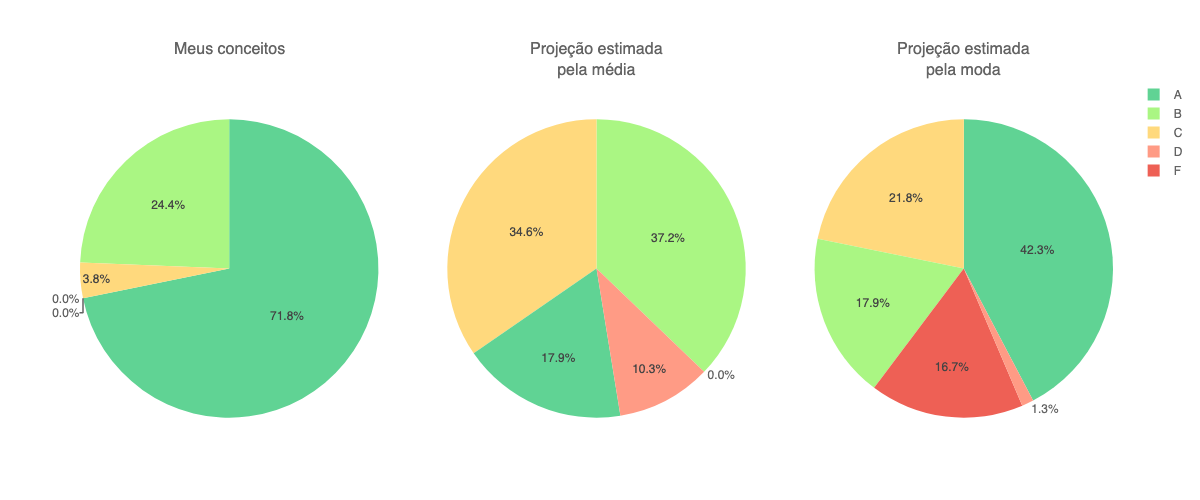

In [13]:
fig_ufabc_grades_prop_comp_pie = make_subplots(rows=1, cols=3, shared_yaxes=True, subplot_titles=SUBPLOT_TITLES, specs=[[{'type': 'pie'}, {'type': 'pie'}, {'type': 'pie'}]])

for col, (prop, name) in enumerate(zip([ufabc_grade_prop, next_prob_grade_prop, next_mode_grade_prop], SUBPLOT_TITLES)):
    x_grades_prop_bar = prop.index
    y_grades_prop_bar = prop.values
    
    grades_prob_bar_colors = [GRADES_COLOR_MAP[grade] for grade in x_grades_prop_bar]
    fig_ufabc_grades_prop_comp_pie.add_trace(go.Pie(labels=x_grades_prop_bar, values=y_grades_prop_bar, name=name, hovertemplate='Conceito %{label}<br>%{percent:.2%}', 
                                              texttemplate='%{percent:.1%}', marker_colors=grades_prob_bar_colors,hoverinfo='label+percent'), row=1, col=col + 1)



# Tirando título para ficar mais clean no HTML. Caso seja necessário add o título de novo: 'Comparativo da proporção de notas na graduação'
fig_ufabc_grades_prop_comp_pie.update_layout({'height': 500, 'margin_t': 80, 'margin_b': 40})
fig_ufabc_grades_prop_comp_pie.write_html('../assets/graphs/ufabc_grades_prop_comp_pie.html')
fig_ufabc_grades_prop_comp_pie.update_layout({'width': 1200} if RENDERER is not None else {}).show(RENDERER)  # Ajusta largura se não estiver como interativo

#### Análise da evolução da proporção de conceitos quadrimestre a quadrimestre

Em seguida, vamos fazer uma comparação da evolução da proporção da minhas notas quadrimestre a quadrimestre. Para fazermos isso, uma das possibilidades é traçar um mapa de calor.

In [14]:
df_ufabc_grades_prop_quad = df_ufabc.groupby('Ano', as_index=False).agg(
    num_A=('Resultado', lambda s: s.value_counts().get('A', default=0)),
    num_B=('Resultado', lambda s: s.value_counts().get('B', default=0)),
    num_C=('Resultado', lambda s: s.value_counts().get('C', default=0)),
    num_D=('Resultado', lambda s: s.value_counts().get('D', default=0)),
    num_F=('Resultado', lambda s: s.value_counts().get('F', default=0))
)

df_ufabc_grades_prop_quad = df_ufabc_grades_prop_quad.sort_values(by='Ano', ascending=True).set_index('Ano', drop=True)
df_ufabc_grades_prop_quad

num_A  num_B  num_C  num_D  num_F
Ano                                      
2017.2      4      0      2      0      0
2017.3      4      0      0      0      0
2018.1      2      2      0      0      0
2018.2      2      2      0      0      0
2018.3      3      1      0      0      0
2019.1      2      3      0      0      0
2019.2      3      3      0      0      0
2019.3      2      2      1      0      0
2020.3      2      1      0      0      0
2021.1      3      1      0      0      0
2021.2      3      1      0      0      0
2021.3      3      1      0      0      0
2022.1      4      0      0      0      0
2022.2      6      0      0      0      0
2022.3      3      1      0      0      0
2023.1      4      0      0      0      0
2023.2      3      1      0      0      0
2023.3      3      0      0      0      0

Se quisermos ver a proporção:

In [15]:
df_ufabc_grades_prop_quad.apply(lambda s: np.round(s/s.sum()*100,1), axis=1)

num_A  num_B  num_C  num_D  num_F
Ano                                      
2017.2   66.7    0.0   33.3    0.0    0.0
2017.3  100.0    0.0    0.0    0.0    0.0
2018.1   50.0   50.0    0.0    0.0    0.0
2018.2   50.0   50.0    0.0    0.0    0.0
2018.3   75.0   25.0    0.0    0.0    0.0
2019.1   40.0   60.0    0.0    0.0    0.0
2019.2   50.0   50.0    0.0    0.0    0.0
2019.3   40.0   40.0   20.0    0.0    0.0
2020.3   66.7   33.3    0.0    0.0    0.0
2021.1   75.0   25.0    0.0    0.0    0.0
2021.2   75.0   25.0    0.0    0.0    0.0
2021.3   75.0   25.0    0.0    0.0    0.0
2022.1  100.0    0.0    0.0    0.0    0.0
2022.2  100.0    0.0    0.0    0.0    0.0
2022.3   75.0   25.0    0.0    0.0    0.0
2023.1  100.0    0.0    0.0    0.0    0.0
2023.2   75.0   25.0    0.0    0.0    0.0
2023.3  100.0    0.0    0.0    0.0    0.0

In [16]:
df_ufabc_grades_prop_quad.apply(lambda s: np.round(s/s.sum()*100,1), axis=1).describe()

num_A      num_B      num_C  num_D  num_F
count   18.000000  18.000000  18.000000   18.0   18.0
mean    72.966667  24.072222   2.961111    0.0    0.0
std     21.022901  20.477241   8.914835    0.0    0.0
min     40.000000   0.000000   0.000000    0.0    0.0
25%     54.175000   0.000000   0.000000    0.0    0.0
50%     75.000000  25.000000   0.000000    0.0    0.0
75%     93.750000  38.325000   0.000000    0.0    0.0
max    100.000000  60.000000  33.300000    0.0    0.0

Além disso, podemos trazer uma visão acumulada, vendo como a proporção acumulada e quantidade acumuladas de conceitos alteraram-se ano após ano.

In [17]:
df_ufabc_grades_cum_quad = df_ufabc.groupby('Ano', as_index=False).agg(
    cum_A=('Resultado', lambda s: s.value_counts().get('A', default=0)),
    cum_B=('Resultado', lambda s: s.value_counts().get('B', default=0)),
    cum_C=('Resultado', lambda s: s.value_counts().get('C', default=0)),
    cum_D=('Resultado', lambda s: s.value_counts().get('D', default=0)),
    cum_F=('Resultado', lambda s: s.value_counts().get('F', default=0)),
)

df_ufabc_grades_cum_quad = df_ufabc_grades_cum_quad.sort_values(by='Ano', ascending=True).set_index('Ano', drop=True)
df_ufabc_grades_cum_quad = df_ufabc_grades_cum_quad.cumsum()
df_ufabc_grades_cum_quad

cum_A  cum_B  cum_C  cum_D  cum_F
Ano                                      
2017.2      4      0      2      0      0
2017.3      8      0      2      0      0
2018.1     10      2      2      0      0
2018.2     12      4      2      0      0
2018.3     15      5      2      0      0
2019.1     17      8      2      0      0
2019.2     20     11      2      0      0
2019.3     22     13      3      0      0
2020.3     24     14      3      0      0
2021.1     27     15      3      0      0
2021.2     30     16      3      0      0
2021.3     33     17      3      0      0
2022.1     37     17      3      0      0
2022.2     43     17      3      0      0
2022.3     46     18      3      0      0
2023.1     50     18      3      0      0
2023.2     53     19      3      0      0
2023.3     56     19      3      0      0

Ou vendo a proporção:

In [18]:
df_ufabc_grades_cum_quad.apply(lambda s: np.round(s/s.sum()*100, 1), axis=1)

cum_A  cum_B  cum_C  cum_D  cum_F
Ano                                      
2017.2   66.7    0.0   33.3    0.0    0.0
2017.3   80.0    0.0   20.0    0.0    0.0
2018.1   71.4   14.3   14.3    0.0    0.0
2018.2   66.7   22.2   11.1    0.0    0.0
2018.3   68.2   22.7    9.1    0.0    0.0
2019.1   63.0   29.6    7.4    0.0    0.0
2019.2   60.6   33.3    6.1    0.0    0.0
2019.3   57.9   34.2    7.9    0.0    0.0
2020.3   58.5   34.1    7.3    0.0    0.0
2021.1   60.0   33.3    6.7    0.0    0.0
2021.2   61.2   32.7    6.1    0.0    0.0
2021.3   62.3   32.1    5.7    0.0    0.0
2022.1   64.9   29.8    5.3    0.0    0.0
2022.2   68.3   27.0    4.8    0.0    0.0
2022.3   68.7   26.9    4.5    0.0    0.0
2023.1   70.4   25.4    4.2    0.0    0.0
2023.2   70.7   25.3    4.0    0.0    0.0
2023.3   71.8   24.4    3.8    0.0    0.0

Assim, podemos combinar os resultados em um subplot com dois heatmaps e comparar com os demais alunos.

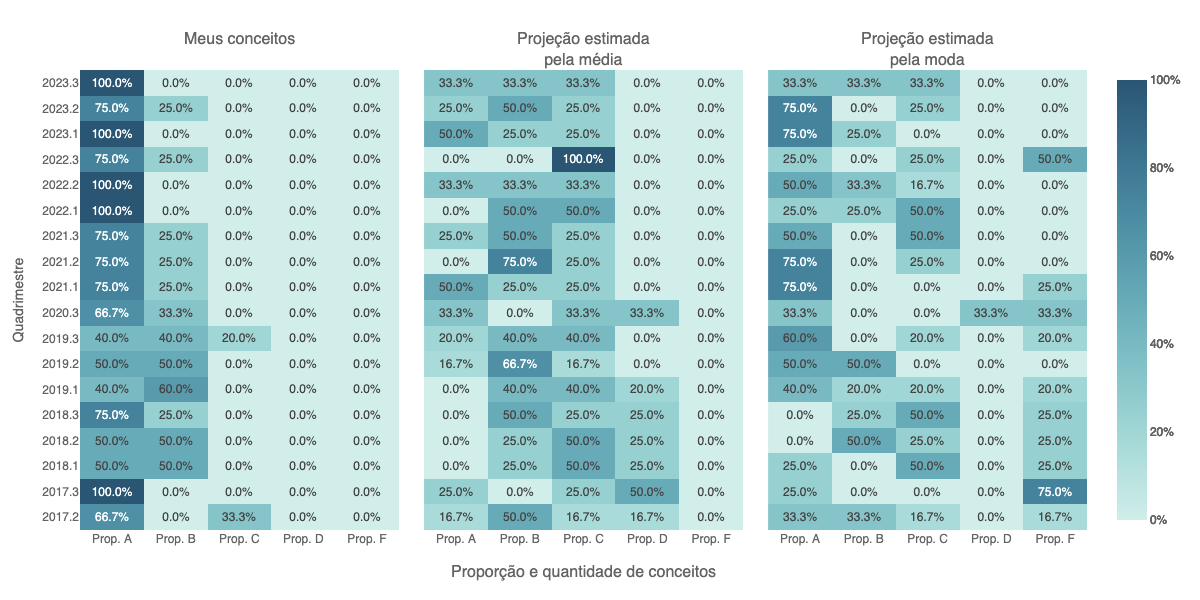

In [19]:
# Só com a proporção
fig_ufabc_grades_prop_cum_quad = make_subplots(rows=1, cols=3, shared_yaxes=True, shared_xaxes=True, horizontal_spacing=0.025, vertical_spacing=0.025,
                                               x_title='Proporção e quantidade de conceitos', subplot_titles=SUBPLOT_TITLES)

# Com a proporção e proporção acumulada
# fig_ufabc_grades_prop_cum_quad = make_subplots(rows=2, cols=3, shared_yaxes=True, shared_xaxes=True, horizontal_spacing=0.025, vertical_spacing=0.025,
#                                                x_title='Proporção e quantidade de conceitos', subplot_titles=SUBPLOT_TITLES)

for col, df_tmp in enumerate([df_ufabc, df_next.rename(columns={'Conceito provável': 'Resultado'}), df_next.rename(columns={'Conceito moda': 'Resultado'})]):
    df_ufabc_grades_prop_quad = df_tmp.groupby('Ano', as_index=False).agg(
        num_A=('Resultado', lambda s: s.value_counts().get('A', default=0)),
        num_B=('Resultado', lambda s: s.value_counts().get('B', default=0)),
        num_C=('Resultado', lambda s: s.value_counts().get('C', default=0)),
        num_D=('Resultado', lambda s: s.value_counts().get('D', default=0)),
        num_F=('Resultado', lambda s: s.value_counts().get('F', default=0))
    )

    df_ufabc_grades_prop_quad = df_ufabc_grades_prop_quad.sort_values(by='Ano', ascending=True).set_index('Ano', drop=True)

    x_grades_prop_quad = [f'Prop. {grade[-1]}' for grade in df_ufabc_grades_prop_quad.columns]
    y_grades_prop_quad = df_ufabc_grades_prop_quad.index
    z_grades_prop_quad = df_ufabc_grades_prop_quad.apply(lambda s: s/s.sum(), axis=1).values
    text_1 = df_ufabc_grades_prop_quad.apply(lambda s: np.round(s/s.sum()*100,1), axis=1).astype(str) + '%'
    # text_1 = df_ufabc_grades_prop_quad.apply(lambda s: np.round(s/s.sum()*100,1), axis=1).astype(str) + '% (' + df_ufabc_grades_prop_quad.astype(str) + ')'
    # text_1 = df_ufabc_grades_prop_quad.apply(lambda s: np.round(s/s.sum()*100,1), axis=1).astype(str) + '%<br>(' + df_ufabc_grades_prop_quad.astype(str) + ' de ' + pd.concat([df_ufabc_grades_prop_quad.sum(axis=1)]*5, axis=1).astype(str).rename(columns={c:cc for c, cc in zip(range(0, 5), df_ufabc_grades_prop_quad)}) + ')'

    fig_ufabc_grades_prop_cum_quad.add_trace(go.Heatmap(x=x_grades_prop_quad, y=y_grades_prop_quad, z=z_grades_prop_quad, text=text_1, name=SUBPLOT_TITLES[col],
                                                        texttemplate='%{text}', zhoverformat='.1%', hovertemplate='%{x} em %{y}<br>%{z:.2%}', # textfont_size=8,
                                                        colorscale=HEATMAP_PALETTE, hoverinfo='x+y+z', colorbar_tickformat='.0%', zmin=0, zmax=1), row=1, col=col + 1)

    
    # df_ufabc_grades_cum_quad = df_tmp.groupby('Ano', as_index=False).agg(
    #     cum_A=('Resultado', lambda s: s.value_counts().get('A', default=0)),
    #     cum_B=('Resultado', lambda s: s.value_counts().get('B', default=0)),
    #     cum_C=('Resultado', lambda s: s.value_counts().get('C', default=0)),
    #     cum_D=('Resultado', lambda s: s.value_counts().get('D', default=0)),
    #     cum_F=('Resultado', lambda s: s.value_counts().get('F', default=0)),
    # )

    # df_ufabc_grades_cum_quad = df_ufabc_grades_cum_quad.sort_values(by='Ano', ascending=True).set_index('Ano', drop=True)
    # df_ufabc_grades_cum_quad = df_ufabc_grades_cum_quad.cumsum()

    # x_grades_prop_cum_quad = [f'Prop. {grade[-1]}' for grade in df_ufabc_grades_cum_quad.columns]
    # y_grades_prop_cum_quad = df_ufabc_grades_cum_quad.index
    # z_grades_prop_cum_quad = df_ufabc_grades_cum_quad.apply(lambda s: s/s.sum(), axis=1).values
    # text_2 = df_ufabc_grades_cum_quad.apply(lambda s: np.round(s/s.sum()*100, 1), axis=1).astype(str) + '% (' + df_ufabc_grades_cum_quad.astype(str) + ')'

    # fig_ufabc_grades_prop_cum_quad.add_trace(go.Heatmap(x=x_grades_prop_cum_quad, y=y_grades_prop_cum_quad, z=z_grades_prop_cum_quad, name=SUBPLOT_TITLES[col],
    #                                                     text=text_2, texttemplate='%{text}', hovertemplate='%{x} em %{y}<br>%{z:.2%}', zhoverformat='.1%', # textfont_size=8,
    #                                                     colorscale=HEATMAP_PALETTE, hoverinfo='x+y+z', zmin=0, zmax=1,colorbar_tickformat='.0%'), row=2, col=col + 1)


# Tirando título para ficar mais clean no HTML. Caso seja necessário add o título de novo: 'Proporção e quantidade de conceitos quadrimestre a quadrimestre na graduação'
fig_ufabc_grades_prop_cum_quad.update_layout({'yaxis_title': 'Quadrimestre', 'height': 600, 'margin_t': 70, 'margin_b': 70})
fig_ufabc_grades_prop_cum_quad.write_html('../assets/graphs/ufabc_grades_prop_cum_quad.html')
fig_ufabc_grades_prop_cum_quad.update_layout({'width': 1200} if RENDERER is not None else {}).show(RENDERER)  # Ajusta largura se não estiver como interativo

#### Análise comparativa da evolução temporal do CR

Feito isso, agora podemos traçar a evolução temporal do CR (Coeficiente de Rendimento) ao longo dos quadrimestres. Este valor é calculado como uma média ponderada da equivalência numérica da nota pela quantidade de créditos:

$$
CR = \frac{\sum_i \text{nota}_i \cdot \text{créditos}_i}{\sum_i \text{créditos}_i}
$$

In [20]:
grades_map = {  # Mapeamento numérico da nota para número
    'A': 4,
    'B': 3,
    'C': 2,
    'D': 1,
    'F': 0
}

quad_map = {
    '1': 1,  # Q1 -> 01 -> 04 (Janeiro até Abril)
    '2': 5,  # Q2 -> 05 -> 08 (Maio -> Agosto)
    '3': 9   # Q3 -> 09 -> 12 (Setembro -> Dezembro)
}

cr_series = df_ufabc.copy().dropna()
cr_series['Nota ponderada'] = cr_series.apply(lambda s: s['Créditos'] * grades_map[s['Resultado']], axis=1)
cr_series = cr_series.groupby('Ano', as_index=False)[['Créditos', 'Nota ponderada']].sum()
cr_series[['Créditos acum', 'Nota ponderada acum']] = cr_series[['Créditos', 'Nota ponderada']].cumsum()
cr_series['CR'] = cr_series.apply(lambda s: s['Nota ponderada acum']/s['Créditos acum'], axis=1)
cr_series['Quadrimestre'] = cr_series['Ano'].apply(lambda s: pd.to_datetime(f'{quad_map[s.split('.')[1]]}/{s.split('.')[0]}')) 
cr_series = cr_series[['Quadrimestre', 'CR']]
cr_series

Quadrimestre        CR
0    2017-05-01  3.176471
1    2017-09-01  3.562500
2    2018-01-01  3.540000
3    2018-05-01  3.553846
4    2018-09-01  3.602410
5    2019-01-01  3.565657
6    2019-05-01  3.551724
7    2019-09-01  3.496241
8    2020-09-01  3.503497
9    2021-01-01  3.531250
10   2021-05-01  3.548023
11   2021-09-01  3.562500
12   2022-01-01  3.598086
13   2022-05-01  3.652893
14   2022-09-01  3.657588
15   2023-01-01  3.675277
16   2023-05-01  3.674912
17   2023-09-01  3.687075

In [21]:
cr_prob_series = df_next.copy().dropna()
cr_prob_series['Nota ponderada'] = cr_prob_series.apply(lambda s: s['Créditos'] * grades_map[s['Conceito provável']], axis=1)
cr_prob_series = cr_prob_series.groupby('Ano', as_index=False)[['Créditos', 'Nota ponderada']].sum()
cr_prob_series[['Créditos acum', 'Nota ponderada acum']] = cr_prob_series[['Créditos', 'Nota ponderada']].cumsum()
cr_prob_series['CR'] = cr_prob_series.apply(lambda s: s['Nota ponderada acum']/s['Créditos acum'], axis=1)
cr_prob_series['Quadrimestre'] = cr_prob_series['Ano'].apply(lambda s: pd.to_datetime(f'{quad_map[s.split('.')[1]]}/{s.split('.')[0]}')) 
cr_prob_series = cr_prob_series[['Quadrimestre', 'CR']]
cr_prob_series

Quadrimestre        CR
0    2017-05-01  2.529412
1    2017-09-01  2.218750
2    2018-01-01  2.160000
3    2018-05-01  2.092308
4    2018-09-01  2.096386
5    2019-01-01  2.101010
6    2019-05-01  2.215517
7    2019-09-01  2.270677
8    2020-09-01  2.251748
9    2021-01-01  2.362500
10   2021-05-01  2.401130
11   2021-09-01  2.432292
12   2022-01-01  2.435407
13   2022-05-01  2.541322
14   2022-09-01  2.509728
15   2023-01-01  2.549815
16   2023-05-01  2.561837
17   2023-09-01  2.568027

In [22]:
cr_mode_series = df_next.copy().dropna()
cr_mode_series['Nota ponderada'] = cr_mode_series.apply(lambda s: s['Créditos'] * grades_map[s['Conceito moda']], axis=1)
cr_mode_series = cr_mode_series.groupby('Ano', as_index=False)[['Créditos', 'Nota ponderada']].sum()
cr_mode_series[['Créditos acum', 'Nota ponderada acum']] = cr_mode_series[['Créditos', 'Nota ponderada']].cumsum()
cr_mode_series['CR'] = cr_mode_series.apply(lambda s: s['Nota ponderada acum']/s['Créditos acum'], axis=1)
cr_mode_series['Quadrimestre'] = cr_mode_series['Ano'].apply(lambda s: pd.to_datetime(f'{quad_map[s.split('.')[1]]}/{s.split('.')[0]}')) 
cr_mode_series = cr_mode_series[['Quadrimestre', 'CR']]
cr_mode_series

Quadrimestre        CR
0    2017-05-01  2.411765
1    2017-09-01  1.656250
2    2018-01-01  1.820000
3    2018-05-01  1.815385
4    2018-09-01  1.771084
5    2019-01-01  1.898990
6    2019-05-01  2.129310
7    2019-09-01  2.172932
8    2020-09-01  2.104895
9    2021-01-01  2.206250
10   2021-05-01  2.322034
11   2021-09-01  2.359375
12   2022-01-01  2.387560
13   2022-05-01  2.541322
14   2022-09-01  2.486381
15   2023-01-01  2.553506
16   2023-05-01  2.586572
17   2023-09-01  2.591837

Plotando as curvas sobrepostas, podemos fazer uma comparação da evolução temporal do meu CR com relação as situações de conceitos mais prováveis e conceitos moda:

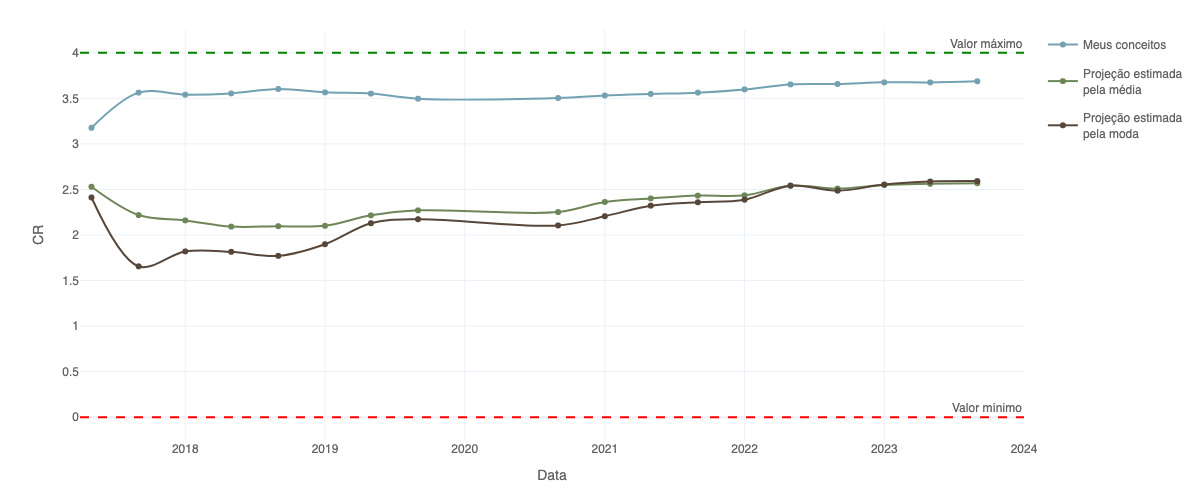

In [23]:
fig_ufabc_cr_comp_series = go.Figure()

fig_ufabc_cr_comp_series.add_trace(go.Scatter(x=cr_series['Quadrimestre'], y=cr_series['CR'], name=SUBPLOT_TITLES[0].replace('<br>&nbsp;', ''), 
                                              line_shape='spline', marker_color=BLUE, hovertemplate='%{y:.2f}', legendgroup=0))
fig_ufabc_cr_comp_series.add_trace(go.Scatter(x=cr_prob_series['Quadrimestre'], y=cr_prob_series['CR'], name=SUBPLOT_TITLES[1], 
                                              line_shape='spline', marker_color=GREEN, hovertemplate='%{y:.2f}', legendgroup=1))
fig_ufabc_cr_comp_series.add_trace(go.Scatter(x=cr_mode_series['Quadrimestre'], y=cr_mode_series['CR'], name=SUBPLOT_TITLES[2], 
                                              line_shape='spline', marker_color=BROWN, hovertemplate='%{y:.2f}', legendgroup=2))
fig_ufabc_cr_comp_series.add_hline(y=4, line_color='green', line_dash='dash', annotation_text='Valor máximo')
fig_ufabc_cr_comp_series.add_hline(y=0, line_color='red', line_dash='dash', annotation_text='Valor mínimo')

# Tirando título para ficar mais clean no HTML. Caso seja necessário add o título de novo: 'Evolução temporal do CR'
fig_ufabc_cr_comp_series.update_layout({'yaxis_title': 'CR', 'xaxis_title': 'Data', 'yaxis_range': [-0.25, 4.25], 'xaxis_range': ['2017-04-01', '2024-01-01'],
                                        'hovermode': 'x unified',  'height': 500, 'legend_tracegroupgap': 10, 'legend_orientation': 'v', # 'legend_title': 'Curvas',
                                        'margin_t': 30, 'margin_b': 60})
fig_ufabc_cr_comp_series.write_html('../assets/graphs/ufabc_cr_comp_series.html')
fig_ufabc_cr_comp_series.update_layout({'width': 1200} if RENDERER is not None else {}).show(RENDERER)  # Ajusta largura se não estiver como interativo

### Análise dos dados do CIn-UFPE

#### Leitura dos dados

Analogamente ao que fizemos antes, como primeiro passo vamos ler os dados das notas do CIn-UFPE.

In [24]:
df_ufpe = pd.read_csv('./data/notas-ufpe.csv', dtype={'Ano': str}, sep=';', decimal=',')
df_ufpe

Ano   Código                             Disciplina  Resultado  \
0   2024.1  CIN0068  APLICAÇÕES DE APRENDIZAGEM DE MÁQUINA        9.9   
1   2024.1  CIN0066              APRENDIZAGEM DE MÁQUINA I       10.0   
2   2024.1  CIN0067             APRENDIZAGEM DE MÁQUINA II       10.0   
3   2024.1  CIN0069       ARQUITETURA BIG DATA E ANALYTICS       10.0   
4   2024.1  CIN0061                ARQUITETURA DE SOFTWARE       10.0   
5   2024.1  CIN0065                   ESTATÍSTICA AVANÇADA        9.5   
6   2024.1  CIN0071             FAMILIARIZAÇÃO AERONÁUTICA       10.0   
7   2024.1  CIN0064          INTRODUÇÃO A CIÊNCIA DE DADOS        9.5   
8   2024.1  CIN0070            PROJETO DE CIÊNCIA DE DADOS       10.0   
9   2024.1  CIN0062                  QUALIDADE DE SOFTWARE       10.0   
10  2024.1  CIN0060                 REQUISITOS DE SOFTWARE        9.5   
11  2024.1  CIN0063                      TÓPICOS AVANÇADOS        9.8   
12  2024.1  LAT0001                TRABALHO FINAL DE CURSO       10.0   

    Situação  
0   APROVADO  
1   APROVADO  
2   APROVADO  
3   APROVADO  
4   APROVADO  
5   APROVADO  
6   APROVADO  
7   APROVADO  
8   APROVADO  
9   APROVADO  
10  APROVADO  
11  APROVADO  
12  APROVADO

Com base nestes dados, verificamos que há redundância quanto as disciplinas "Projeto de Ciência de Dados" e "Trabalho Final de Curso", visto que estes referem-se a mesma coisa. Isto posto, vamos remover o registro com "Projeto de Ciência de Dados".

In [25]:
df_ufpe = df_ufpe[df_ufpe['Disciplina'] != 'PROJETO DE CIÊNCIA DE DADOS']
df_ufpe

Ano   Código                             Disciplina  Resultado  \
0   2024.1  CIN0068  APLICAÇÕES DE APRENDIZAGEM DE MÁQUINA        9.9   
1   2024.1  CIN0066              APRENDIZAGEM DE MÁQUINA I       10.0   
2   2024.1  CIN0067             APRENDIZAGEM DE MÁQUINA II       10.0   
3   2024.1  CIN0069       ARQUITETURA BIG DATA E ANALYTICS       10.0   
4   2024.1  CIN0061                ARQUITETURA DE SOFTWARE       10.0   
5   2024.1  CIN0065                   ESTATÍSTICA AVANÇADA        9.5   
6   2024.1  CIN0071             FAMILIARIZAÇÃO AERONÁUTICA       10.0   
7   2024.1  CIN0064          INTRODUÇÃO A CIÊNCIA DE DADOS        9.5   
9   2024.1  CIN0062                  QUALIDADE DE SOFTWARE       10.0   
10  2024.1  CIN0060                 REQUISITOS DE SOFTWARE        9.5   
11  2024.1  CIN0063                      TÓPICOS AVANÇADOS        9.8   
12  2024.1  LAT0001                TRABALHO FINAL DE CURSO       10.0   

    Situação  
0   APROVADO  
1   APROVADO  
2   APROVADO  
3   APROVADO  
4   APROVADO  
5   APROVADO  
6   APROVADO  
7   APROVADO  
9   APROVADO  
10  APROVADO  
11  APROVADO  
12  APROVADO

Nesta especialização, as matérias foram cursadas uma por vez. Todavia, como não temos a informação da ordem no Sigaa, vamos adicionar isto manualmente.

In [26]:
subjects_order = {
    'REQUISITOS DE SOFTWARE': 1,
    'FAMILIARIZAÇÃO AERONÁUTICA': 2,
    'ARQUITETURA DE SOFTWARE': 3,
    'QUALIDADE DE SOFTWARE': 4, 
    'TÓPICOS AVANÇADOS': 5, 
    'INTRODUÇÃO A CIÊNCIA DE DADOS': 6, 
    'ESTATÍSTICA AVANÇADA': 7, 
    'APRENDIZAGEM DE MÁQUINA I': 8, 
    'APRENDIZAGEM DE MÁQUINA II': 9,
    'ARQUITETURA BIG DATA E ANALYTICS': 10, 
    'APLICAÇÕES DE APRENDIZAGEM DE MÁQUINA': 11,
    'TRABALHO FINAL DE CURSO': 12
}

df_ufpe['Ordem'] = df_ufpe['Disciplina'].apply(lambda s: subjects_order[s])
df_ufpe = df_ufpe.sort_values('Ordem').reset_index(drop=True)
df_ufpe

Ano   Código                             Disciplina  Resultado  \
0   2024.1  CIN0060                 REQUISITOS DE SOFTWARE        9.5   
1   2024.1  CIN0071             FAMILIARIZAÇÃO AERONÁUTICA       10.0   
2   2024.1  CIN0061                ARQUITETURA DE SOFTWARE       10.0   
3   2024.1  CIN0062                  QUALIDADE DE SOFTWARE       10.0   
4   2024.1  CIN0063                      TÓPICOS AVANÇADOS        9.8   
5   2024.1  CIN0064          INTRODUÇÃO A CIÊNCIA DE DADOS        9.5   
6   2024.1  CIN0065                   ESTATÍSTICA AVANÇADA        9.5   
7   2024.1  CIN0066              APRENDIZAGEM DE MÁQUINA I       10.0   
8   2024.1  CIN0067             APRENDIZAGEM DE MÁQUINA II       10.0   
9   2024.1  CIN0069       ARQUITETURA BIG DATA E ANALYTICS       10.0   
10  2024.1  CIN0068  APLICAÇÕES DE APRENDIZAGEM DE MÁQUINA        9.9   
11  2024.1  LAT0001                TRABALHO FINAL DE CURSO       10.0   

    Situação  Ordem  
0   APROVADO      1  
1   APROVADO      2  
2   APROVADO      3  
3   APROVADO      4  
4   APROVADO      5  
5   APROVADO      6  
6   APROVADO      7  
7   APROVADO      8  
8   APROVADO      9  
9   APROVADO     10  
10  APROVADO     11  
11  APROVADO     12

Feito isto, como primeiro passo vamos ver a distribuição das notas de forma visual. Como, neste caso, não temos nenhuma outra base para compara, vamos trazer as representações apenas para as minhas notas.

#### Análise da distribuição das notas

Como temos poucos dados, o histograma não mostra-se uma representação tão valiosa e informativa. Isto posto, para verificar a distribuiçõ das notas usaremos apenas um boxplot.

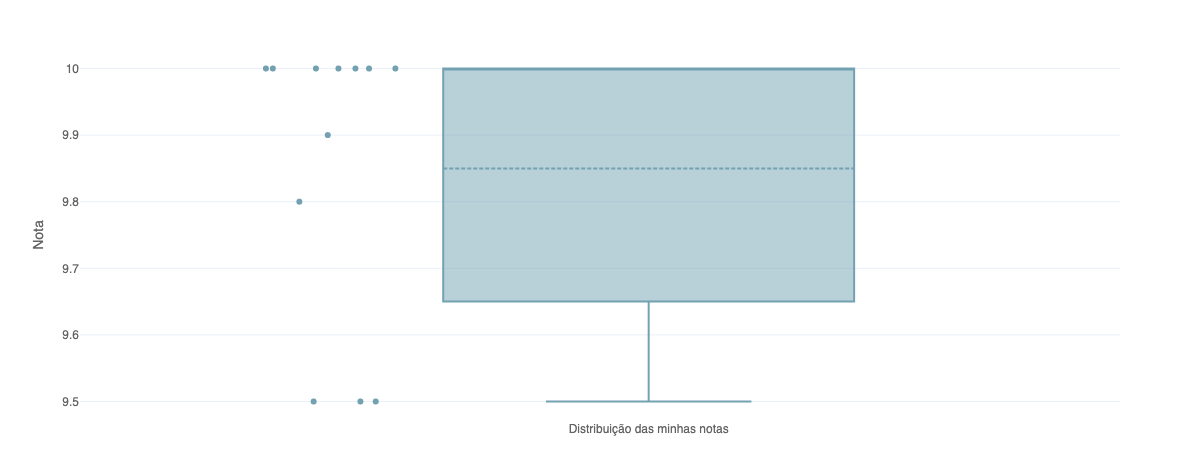

In [27]:
fig_ufpe_grades_dist = go.Figure()
fig_ufpe_grades_dist.add_trace(go.Box(y=df_ufpe['Resultado'], x0='Distribuição das minhas notas', name='Distribuição das minhas notas', boxmean=True,
                                      boxpoints='all', jitter=1, meta=df_ufpe['Disciplina'], hovertemplate='%{meta}: %{y:.2f}', marker_color=BLUE))

# Tirando título para ficar mais clean no HTML. Caso seja necessário add o título de novo: 'Distribuição das notas na pós-graduação'
fig_ufpe_grades_dist.update_layout({'yaxis_title': 'Nota', 'height': 450,'margin_t': 50, 'margin_b': 30})
fig_ufpe_grades_dist.write_html('../assets/graphs/ufpe_grades_dist.html')
fig_ufpe_grades_dist.update_layout({'width': 1200} if RENDERER is not None else {}).show(RENDERER)  # Ajusta largura se não estiver como interativo

#### Nota matéria a matéria

Como, neste caso, são poucas matérias (12), conseguimos sumarizar os resultados um gráfico de barras que mostra cada nota individualmente. Para facilitar na legibilidade, vamos criar um mapeamento com o novo nome das matérias.

In [28]:
df_ufpe['Disciplina'].value_counts()

Disciplina
REQUISITOS DE SOFTWARE                   1
FAMILIARIZAÇÃO AERONÁUTICA               1
ARQUITETURA DE SOFTWARE                  1
QUALIDADE DE SOFTWARE                    1
TÓPICOS AVANÇADOS                        1
INTRODUÇÃO A CIÊNCIA DE DADOS            1
ESTATÍSTICA AVANÇADA                     1
APRENDIZAGEM DE MÁQUINA I                1
APRENDIZAGEM DE MÁQUINA II               1
ARQUITETURA BIG DATA E ANALYTICS         1
APLICAÇÕES DE APRENDIZAGEM DE MÁQUINA    1
TRABALHO FINAL DE CURSO                  1
Name: count, dtype: int64

In [29]:
subjects_split_map = {
    'REQUISITOS DE SOFTWARE': 'REQUISITOS DE<br>SOFTWARE',
    'FAMILIARIZAÇÃO AERONÁUTICA': 'FAMILIARIZAÇÃO<br>AERONÁUTICA',
    'ARQUITETURA DE SOFTWARE': 'ARQUITETURA DE<br>SOFTWARE',
    'QUALIDADE DE SOFTWARE': 'QUALIDADE DE<br>SOFTWARE', 
    'TÓPICOS AVANÇADOS': 'TÓPICOS<br>AVANÇADOS',
    'INTRODUÇÃO A CIÊNCIA DE DADOS': 'INTRODUÇÃO<br>A CIÊNCIA DE<br>DADOS',  
    'ESTATÍSTICA AVANÇADA': 'ESTATÍSTICA<br>AVANÇADA',  
    'APRENDIZAGEM DE MÁQUINA I': 'APRENDIZAGEM<br>DE MÁQUINA I',
    'APRENDIZAGEM DE MÁQUINA II': 'APRENDIZAGEM<br>DE MÁQUINA II',
    'ARQUITETURA BIG DATA E ANALYTICS': 'ARQUITETURA BIG<br>DATA E ANALYTICS',
    'APLICAÇÕES DE APRENDIZAGEM DE MÁQUINA': 'APLICAÇÕES DE<br>APRENDIZAGEM DE<br>MÁQUINA',
    'TRABALHO FINAL DE CURSO': 'TRABALHO FINAL<br>DE CURSO'
}

fig_ufpe_grades_values = go.Figure()
fig_ufpe_grades_values.add_trace(go.Bar(x=df_ufpe['Disciplina'].map(subjects_split_map), y=df_ufpe['Resultado'], name='Notas por matéria',
                                        marker_color=BLUE, hovertemplate='%{x}: %{y:.1f}'))
fig_ufpe_grades_values.add_hline(y=df_ufpe['Resultado'].mean(), annotation_text=f'Média: {df_ufpe['Resultado'].mean():.2f}',
                                 annotation_position='top right', annotation_y=df_ufpe['Resultado'].mean() + 0.2, line_dash='dash')
# Tirando título para ficar mais clean no HTML. Caso seja necessário add o título de novo: 'Notas por matéria da pós-graduação'
fig_ufpe_grades_values.update_layout({'yaxis_title': 'Nota', 'xaxis_title': 'Matéria', 'bargap': 0.3, 'yaxis_dtick': 1, 'height': 500,
                                      'xaxis_tickangle': 45, 'xaxis_tickfont_size': 11, 'yaxis_range': [0, 10.5], 'margin_t': 40, 'margin_b': 60})
fig_ufpe_grades_values.write_html('../assets/graphs/ufpe_grades_values.html')
fig_ufpe_grades_values.update_layout({'width': 1200} if RENDERER is not None else {}).show(RENDERER)  # Ajusta largura se não estiver como interativo

#### Evolução temporal da nota média

Para verificarmos a evolução temporal da nota média, podemos aplicar o método expanding com a média:

In [30]:
mean_grade_evo = df_ufpe[['Ordem', 'Resultado']]
mean_grade_evo['Resultado'] = mean_grade_evo['Resultado'].expanding().mean()
mean_grade_evo

Ordem  Resultado
0       1   9.500000
1       2   9.750000
2       3   9.833333
3       4   9.875000
4       5   9.860000
5       6   9.800000
6       7   9.757143
7       8   9.787500
8       9   9.811111
9      10   9.830000
10     11   9.836364
11     12   9.850000

Para este caso, podemos usar uma representação semelhante aquela utilizada para a evolução temporal do CR da graduação:

In [31]:
fig_ufpe_mean_grade_evo = go.Figure()

fig_ufpe_mean_grade_evo.add_trace(go.Scatter(x=mean_grade_evo['Ordem'], y=mean_grade_evo['Resultado'], name='Meus conceitos', 
                                             line_shape='spline', hovertemplate='Nota média: %{y:.2f}', marker_color=BLUE))
fig_ufpe_mean_grade_evo.add_hline(y=10, line_color='green', line_dash='dash', annotation_text='Valor máximo')
fig_ufpe_mean_grade_evo.add_hline(y=0, line_color='red', line_dash='dash', annotation_text='Valor mínimo')

# Tirando título para ficar mais clean no HTML. Caso seja necessário add o título de novo: 'Evolução temporal da nota média da pós-graduação'
fig_ufpe_mean_grade_evo.update_layout({'height': 500, 'xaxis_range': [0.5, 12.5], 'xaxis_dtick': 1, 'yaxis_title': 'Nota média', 
                                       'xaxis_title': 'Índice da matéria', 'yaxis_range': [9.4, 10.05], 'margin_t': 30, 
                                       'margin_b': 60})
fig_ufpe_mean_grade_evo.write_html('../assets/graphs/ufpe_mean_grade_evos.html')
fig_ufpe_mean_grade_evo.update_layout({'width': 1200} if RENDERER is not None else {}).show(RENDERER)  # Ajusta largura se não estiver como interativo